### Parte 1: Importación de los datos

El objetivo de este fichero es documentar el proceso de importación de los datos que formarán la entrada de nuestro modelo. Los puntos a tratar son los siguientes: 
- [Ir a 1.1. Nuestros datos](#11-nuestros-datos)
- [Ir a 1.2. Tipo de archivos](#12-tipo-de-archivos)
- [Ir a 1.3. Visualización de los archivos](#13-visualizacion-de-los-archivos)
- [Ir a 1.4. Tratamiento archivos baja resolución](#14-tratamiento-archivos-baja-resolucion)
- [Ir a 1.5. Punto de partida ](#15-punto-de-partida)

#### 1.1 Nuestros datos

Los datos con los que se trabajará provienen de simulaciones realizadas a través del modelo WRF en dos dominios en particular: de 3km (d03) y 333m (d05) sobre la zona austral de Chile. El primer dominio constituye los datos de baja resolución (los que se quiere desescalar) y el segundo dominio desprende los datos de alta resolución (los datos objetivos o target). 

<center>

| ![Imagen 1](extra/img/d03_3km.png){: style="width:400px"} | ![Imagen 2](extra/img/d05_300m.png){: style="width:500px"} |
|:----------------------------------:|:----------------------------------:|
|      Figura 1: Dominio d03 baja resolución       |      Figura 2: Dominio d05 alta resolución      |

</center>

Sobre estos dominios, se realizaron simulaciones para 32 fechas que cubren desde el año 2015 hasta el año 2022 aproximadamente. Cada fecha simulada contempla 120 mapas de viento, uno para cada hora, desde la fecha simulada hasta cuatro días a futuro. Las dos primeras columnas de fechas conformarán el conjunto de entrenamiento de la red, la segunda columna conformará el conjunto de validación y la restante el conjunto de testeo. A continuación se provee la cantidad de mapas que conformará cada conjunto y las fechas simuladas.

<center>

| Conjunto | Cantidad de mapas |
| ------   | --------------    |
| Entrenamiento | 120 mapas $\cdot$ 16 fechas = 1920 | 
| Validación | 120 mapas $\cdot$ 8 fechas = 960|
| Testeo | 120 mapas $\cdot$ 8 fechas = 960 |
</center>

<br> <br>
<div style="text-align: center;">
    <img src="extra/img/casos_simuladas.png" alt="Fechas simuladas para ambos dominios" style="width: 500px;">
    <p>Figura 3: Fechas simuladas para ambos dominios</p>
</div>

#### 1.2 Tipo de archivos

Los archivos originales se encuentran almacenados en el servidor SIVAR. Las simulaciones están ordenadas por fechas simuladas y cada fecha contiene 240* simulaciones (120 sobre d03 y 120 sobre d05 sobre el mismo horario). 

***Nota**: Algunos casos contienen 242 y otros 240 simulaciones dependiendo de si se simuló el tiempo 00:00 del quinto día. En la anterior explicación estamos asumiendo que cada carpeta contiene unicamente 240 simulaciones.

<center>

| ![Imagen 1](img/carpetas.png){: style="width:300px"} | ![Imagen 2](img/archivos_simulados.png){: style="width:400px"} |
|:----------------------------------:|:----------------------------------:|
|      Figura 4: Primeras 10 carpetas que contienen las simulaciones por fecha     |      Figura 5: Archivos simulados contenidos en cada carpeta. Cada archivo contiene el mapa correspondiente a su resolución y tiempo     |

</center>

#### 1.3. Visualización de los archivos.

Para ejemplificar y obtener una mayor comprensión de la data con la cual estamos trabajando, se importará un par de archivos correspondientes al mismo registro temporal y así observar diferencias. Los archivos en cuestión dan cuenta de la fecha simulada: 12:00 pm del día 2015/10/21. Estos archivos pueden ser abiertos a través de los métodos de las librerías ```netCDF4```, ```WRF``` o ```xarray```.

Abramos el archivo correspondiente al dominio d03 y veamos qué variables contiene:

In [1]:
import xarray as xr
import warnings
warnings.filterwarnings("ignore")


path = "files/wrfout_d03_2015-10-25_12%3A00%3A00" #ruta del archivo
output = xr.open_dataset(path)
print("Cantidad de variables simuladas: ", len(output.data_vars))
print("Nombre de las primeras 10 variables simuladas ", list(output.data_vars)[:10])

Cantidad de variables simuladas:  155
Nombre de las primeras 10 variables simuladas  ['Times', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'BATHYMETRY_FLAG', 'U', 'V']


Se puede apreciar cómo un solo archivo contiene simulaciones para 155 variables obtenidas a través del modelo WRF. Más adelante entraremos en detalles sobre qué contiene alguna de ellas. Ahora bien, fijemos la variable "HGT" correspondiente al Terrain Height. Miremos rápidamente su descripción

In [6]:
output.data_vars["HGT"]

<xarray.DataArray 'HGT' (Time: 1, south_north: 171, west_east: 81)> Size: 55kB
[13851 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 55kB ...
    XLONG    (Time, south_north, west_east) float32 55kB ...
    XTIME    (Time) datetime64[ns] 8B ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Terrain Height
    units:        m
    stagger:

In [3]:
from netCDF4 import Dataset
from wrf import getvar

d03_file = Dataset("files/wrfout_d03_2015-10-25_12%3A00%3A00") #Puede importar más de un archivo al mismo tiempo
d05_file = Dataset("files/wrfout_d05_2015-10-25_12%3A00%3A00")

d03_hgt = getvar(d03_file, "HGT")
d05_hgt = getvar(d05_file, "HGT")

print("Cantidad de valores dominio baja resolución (d03): ", d03_hgt.shape)
print("Cantidad de valores dominio alta resolución (d05): ", d05_hgt.shape)

Cantidad de valores dominio baja resolución (d03):  (171, 81)
Cantidad de valores dominio alta resolución (d05):  (390, 426)


La cantidad de valores que contendrá cada mapa de baja resolución corresponde a $(171,81)$ mientras que la cantidad de valores a alta resolución corresponde a $(390,426)$. Esta diferencia, pese a ser obvia, resulta relevante ya que implica realizar un proceso de ajuste de grillas para conseguir la misma cantidad de puntos en ambos tensores. 

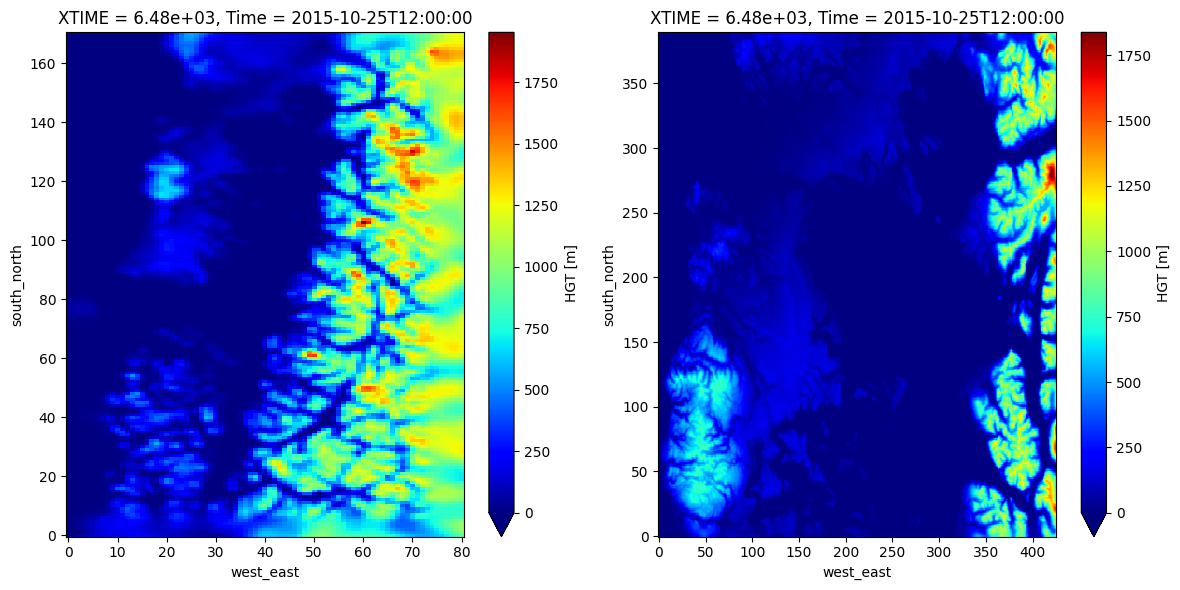

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

d03_hgt.plot(ax=ax1, cmap="jet", vmin=0)
d05_hgt.plot(ax=ax2, cmap="jet", vmin=0)
plt.tight_layout()
plt.show()


La anterior figura muestra los datos relacionados al *Terrain Height* de ambos dominios. Rápidamente podemos visualizar la diferencia en el detalle causada por la diferencia de resolución. Por ejemplo, el Canal de Chacao (alrededor de la zona ubicada en 140-30 del d03 y 270-150 en d05) pasa prácticamente inadvertido en el dominio d03 (fig. izquierda) mientras que en el dominio de alta resolución se puede apreciar detalladamente. Lo anterior es relevante para comprender la importancia de poder captar estos detalles ocultos a través de la integración de variables atmosféricas que complementen los fenómenos que suceden alrededor de zonas topográficas donde el detalle no es el óptimo. 

Otro punto importante a destacar es la diferencia entre las zonas abarcadas por los distintos dominios. Para efectos del trabajo a futuro, se acotará el dominio de baja resolución para que tenga las mismas fronteras que el dominio de alta resolución. 

Lo último, debido a que el ploteo mostrado tenía un fin únicamente didáctico, no se procuró modificar la información complementaria de los ejes, título o colorbar y solo se trabajó con el método por defecto. El único detalle que se modificó fue el valor mínimo de ambos ejes (se fijó en 0 metros) para que el colormap facilitara la visualización de los detalles.

#### 1.4. Tratamiento archivos baja resolucion

Como se dijo en el punto anterior, dos son lo pasos importantes en el tratamiento de los archivos d03: (1) restricción del dominio para que coincida con el de alta resolución (dominio de interés) y (2) interpolación para igualar la cantidad de puntos de ambas grillas. Estos procesos de detallan en: [Test_11.ipynb (Ángel Santos)](https://github.com/sivar-austral/AS_Sivar/blob/main/Test_11.ipynb) y se aplicará para cada variable a trabajar.

<center>

| ![Imagen 1](img/d03_interpolado.png){: style="width:500px"} | ![Imagen 2](img/d05_interpolado.png){: style="width:500px"} |
|:----------------------------------:|:----------------------------------:|
|      Figura 6: Dominio d03 cortado e interpolado con vecino más cercano  (Ángel Santos)   |      Figura 7: Dominio d05 objetivo  (Ángel Santos)|

</center>

Por último, cada mapa será dividido en parches de tamaño $32 \times 32 $ como estrategia para facilitar el entrenamiento del modelo. Sin embargo, esta estrategia se puede considerar como un hiperparámetro y por tanto, se pueden probar otros enfoques: parches de tamaño $64 \times 64$ o el dominio completo. 

<center>

| ![Imagen 1](img/dominio_original.png){: style="width:500px"} | ![Imagen 2](img/dominio_dividido.png){: style="width:500px"} |
|:----------------------------------:|:----------------------------------:|
|      Figura 8: Dominio d03 original   |    Figura 9: Dominio do3 reconstruido por cuadrantes|

</center>

<br> <br>
A través de este enfoque, el conjunto de entrenamiento estará conformado por 299520 parches mientras que el conjunto de validación contendrán ambos 149760 parches.

<center>


| Conjunto | Cantidad de mapas |
| ------   | --------------    |
| Entrenamiento | 120 mapas $\cdot$ 16 fechas $\cdot$ 156 cuadrantes = 299520 | 
| Validación | 120 mapas $\cdot$ 8 fechas $\cdot$ 156 cuadrantes = 149760|
| Testeo | 120 mapas $\cdot$ 8 fechas $\cdot$ 156 cuadrantes = 149760 |
</center>

#### 1.5. Punto de partida 
El punto de partida de nuestro trabajo comienza una vez ejecutado el script: [as_saving_patches.py (Ángel Santos)](https://github.com/sivar-austral/AS_Sivar/blob/main/as_saving_patches.py). Este script toma los datos originales (ver Fig. 4 y Fig. 5) y extrae, utilizando el mismo formato de orden de archivos, las variables especificadas y las guarda como archivos ```.npy``` para cada registro horario. Para el caso de los archivos d03, estos son cortados e interpolados para compatibilizar la cantidad de puntos con los archivos d05. Las siguientes figuras muestran el resultado de la ejecución del script ```as_saving_patches.py```.


<center>

| ![Imagen 1](img/variables_creadas.png){: style="width:400px"} | ![Imagen 2](img/mismo_formato.png){: style="width:400px"} |  ![Imagen 2](img/parches_creados.png){: style="width:400px"} |
|:----------------------------------:|:----------------------------------:| :----------------------------------:|
|      Figura 10: Carpetas creadas por variable especificada   |     Figura 11: Mismo formato de guardado de información por casos|  Figura 12: Archivos .npy que contienen los 156 parches para cada registro horario para cada caso|

</center>


